<a href="https://colab.research.google.com/github/Vipin8990/python-Datascience/blob/main/wildfire4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jswlakvipin","key":"839c31973189d0a3d59ba783d7f068a3"}'}

In [7]:
!pip install -q kaggle

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [9]:
!kaggle datasets download -d abdelghaniaaba/wildfire-prediction-dataset

Dataset URL: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset
License(s): other
 99% 1.44G/1.45G [00:06<00:00, 292MB/s]
100% 1.45G/1.45G [00:06<00:00, 231MB/s]


In [10]:
!unzip /content/wildfire-prediction-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: valid/nowildfire/-73.465183,45.443641.jpg  
  inflating: valid/nowildfire/-73.465388,45.584881.jpg  
  inflating: valid/nowildfire/-73.469451,45.480331.jpg  
  inflating: valid/nowildfire/-73.471252,45.51974.jpg  
  inflating: valid/nowildfire/-73.472693,45.427766.jpg  
  inflating: valid/nowildfire/-73.473015,45.435254.jpg  
  inflating: valid/nowildfire/-73.475051,45.56612.jpg  
  inflating: valid/nowildfire/-73.477079,45.597274.jpg  
  inflating: valid/nowildfire/-73.478813,45.555686.jpg  
  inflating: valid/nowildfire/-73.479478,45.524618.jpg  
  inflating: valid/nowildfire/-73.480135,45.528248.jpg  
  inflating: valid/nowildfire/-73.480722,45.518864.jpg  
  inflating: valid/nowildfire/-73.481149,45.563113.jpg  
  inflating: valid/nowildfire/-73.481422,45.559789.jpg  
  inflating: valid/nowildfire/-73.481565,45.467244.jpg  
  inflating: valid/nowildfire/-73.483407,45.637554.jpg  
  inflating: valid/nowildfire/-73.48589

In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [12]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization

In [13]:
# Define image directories and file paths
image_dir_train = Path('/content/train')
image_dir_val = Path('/content/valid')
image_dir_test = Path('/content/test')

In [14]:
filepaths_train = list(image_dir_train.glob(r'**/*.jpg'))
filepaths_val = list(image_dir_val.glob(r'**/*.jpg'))
filepaths_test = list(image_dir_test.glob(r'**/*.jpg'))

In [15]:
# Load labels
labels_train = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_train))
labels_val = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_val))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths_test))

In [16]:
# Create dataframes
filepaths_train = pd.Series(filepaths_train, name='Filepath').astype(str)
labels_train = pd.Series(labels_train, name='Label')
image_df_train = pd.concat([filepaths_train, labels_train], axis=1)

In [17]:
filepaths_val = pd.Series(filepaths_val, name='Filepath').astype(str)
labels_val = pd.Series(labels_val, name='Label')
image_df_val = pd.concat([filepaths_val, labels_val], axis=1)

In [18]:
filepaths_test = pd.Series(filepaths_test, name='Filepath').astype(str)
labels_test = pd.Series(labels_test, name='Label')
image_df_test = pd.concat([filepaths_test, labels_test], axis=1)

In [19]:
# Define data generators
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [20]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_images = train_generator.flow_from_dataframe(
    dataframe=image_df_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

Found 24200 validated image filenames belonging to 2 classes.


In [21]:
val_images = train_generator.flow_from_dataframe(
    dataframe=image_df_val,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=image_df_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)


Found 1260 validated image filenames belonging to 2 classes.
Found 6300 validated image filenames belonging to 2 classes.


In [22]:
# Define CNN model
def create_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(224, 224, 3)))

    # Convolutional layers
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    # Flatten and dense layers
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Create and compile the model
model = create_model()

# Summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 16)      64        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      4640      
                                                        

In [23]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=3
        )
    ]
)


Epoch 1/10
379/379 [==============================] - 351s 897ms/step - loss: 0.2020 - accuracy: 0.9203 - val_loss: 0.2121 - val_accuracy: 0.9603 - lr: 0.0010
Epoch 2/10
379/379 [==============================] - 344s 907ms/step - loss: 0.1605 - accuracy: 0.9377 - val_loss: 0.0616 - val_accuracy: 0.9849 - lr: 0.0010
Epoch 3/10
379/379 [==============================] - 339s 896ms/step - loss: 0.1471 - accuracy: 0.9437 - val_loss: 0.0481 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 4/10
379/379 [==============================] - 342s 902ms/step - loss: 0.1364 - accuracy: 0.9483 - val_loss: 0.0923 - val_accuracy: 0.9714 - lr: 0.0010
Epoch 5/10
379/379 [==============================] - 346s 913ms/step - loss: 0.1270 - accuracy: 0.9514 - val_loss: 0.1877 - val_accuracy: 0.9190 - lr: 0.0010
Epoch 6/10
379/379 [==============================] - 338s 892ms/step - loss: 0.1215 - accuracy: 0.9549 - val_loss: 0.0336 - val_accuracy: 0.9865 - lr: 0.0010
Epoch 7/10
379/379 [==========================

In [24]:
# Evaluate the model on test data
results = model.evaluate(test_images)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1] * 100)


99/99 [==============================] - 18s 175ms/step - loss: 0.0569 - accuracy: 0.9786
Test Loss: 0.05688200145959854
Test Accuracy: 97.85714149475098


In [25]:
# Save the model and its weights
model.save('forest_fire_detection_model.h5')
model.save_weights('forest_fire_detection_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
# Generate predictions and plot confusion matrix
predictions = (model.predict(test_images) > 0.5).astype("int32")
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])


99/99 [==============================] - 18s 171ms/step


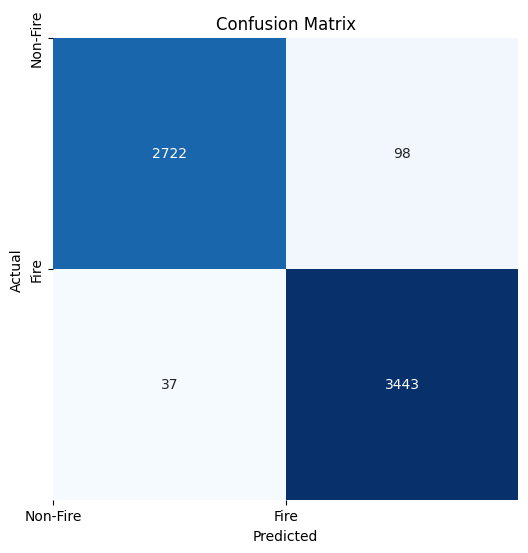

In [27]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0, 1], labels=["Non-Fire", "Fire"])
plt.yticks(ticks=[0, 1], labels=["Non-Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

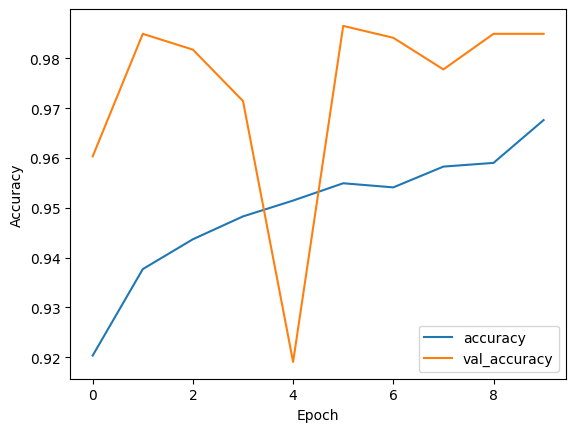

In [28]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

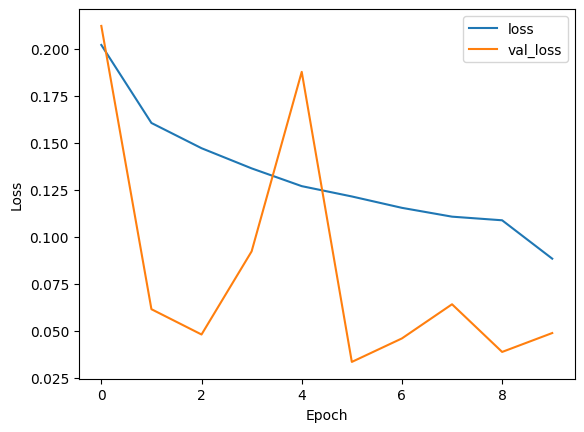

In [29]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()